In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt

from torch.distributions import Categorical, Normal

from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, classification_report

from core import Critic, Actor, Episode, ReplayBuffer
from mdn import MDN
from ud_sac import sample_episode

# MDN test

In [13]:
mdn = MDN(input_size=1, output_size=1, n_heads=2)
mdn_optimizer = torch.optim.Adam(mdn.parameters())

for epoch in range(1000):
    X = np.random.normal(-5.0, 3.0, size=(10, 1))
    mask = np.random.uniform(size=(10, 1)) < 0.5
    Y = (1.0 * mask + 3.0 * mask).reshape(-1, 1) + np.random.normal(size=(10, 1))

    X, Y = torch.tensor(X).float(), torch.tensor(Y).float()

    log_alpha, mu, sigma = mdn(X)
    loss = mdn.nll_loss(log_alpha, mu, sigma, Y)
    
    mdn_optimizer.zero_grad()
    loss.backward()
    mdn_optimizer.step()

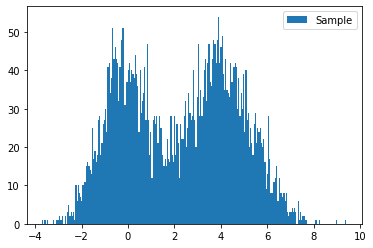

In [14]:
X_test = torch.full((5000, 1), -5.0).float()
log_alpha, mu, sigma = mdn(X_test)

plt.hist(mdn.sample(log_alpha, mu, sigma).numpy(), bins=256, label="Sample");
plt.legend();

# Critic test

In [47]:
def sample_random_batch(env_name, num_episodes=256, batch_size=512):    
    env = gym.make(env_name)
    buffer = ReplayBuffer()
    
    episodes = [sample_episode(env, None, None) for _ in range(num_episodes)]
    buffer.add_episodes(episodes)
    
    return buffer.sample(batch_size)

In [48]:
state, command, action, reward, output = sample_random_batch("LunarLander-v2")

state = torch.tensor(state, dtype=torch.float32)
command = torch.tensor(command, dtype=torch.float32)

action = torch.tensor(action, dtype=torch.float32)
action = F.one_hot(action.long(), num_classes=4)

reward = torch.tensor(reward, dtype=torch.float32)
output = torch.tensor(output, dtype=torch.float32)

In [52]:
command.mean(dim=0), output.mean(dim=0)

(tensor([42.9259,  1.0000]), tensor([-151.3599,   57.5430]))

In [57]:
critic = Critic(8, 4, 2, n_heads=5)
critic_optim = torch.optim.Adam(critic.parameters())

In [58]:
for epoch in range(5000):    
    loss = critic.nll_loss(state, command, action, output)
    
    if epoch % 100 == 0:
        print(loss.item())
    
    critic_optim.zero_grad()
    loss.backward()
    critic_optim.step()

3131.34521484375
24.814733505249023
19.519298553466797
16.86465072631836
13.586235046386719
11.695527076721191
11.356331825256348
11.236328125
11.176101684570312
11.138763427734375
11.096809387207031
11.054011344909668
10.998740196228027
10.933685302734375
10.831304550170898
10.530984878540039
10.113804817199707
9.740209579467773
9.54321002960205
9.454208374023438
9.393375396728516
9.340014457702637
9.29662799835205
9.251927375793457
9.208198547363281
9.174097061157227
9.151342391967773
9.122060775756836
9.09626293182373
9.074480056762695
9.050271034240723
9.023994445800781
9.006122589111328
8.985033988952637
8.942856788635254
8.901782035827637
8.87863826751709
8.844869613647461
9.164216995239258
8.896984100341797
8.840546607971191
8.787022590637207
8.753522872924805
8.724807739257812
8.700261116027832
8.679671287536621
8.659518241882324
8.634709358215332
8.61285400390625
8.590161323547363


In [61]:
test_episode = sample_episode(gym.make("LunarLander-v2"), None, None)

test_init_state = torch.tensor(test_episode.states[0]).unsqueeze(0).float()
test_init_command = torch.tensor(test_episode.commands[0]).unsqueeze(0).float()
test_init_action = F.one_hot(torch.tensor(test_episode.actions[0]), num_classes=4).unsqueeze(0).float()

tensor([-121.1964,   65.2479])


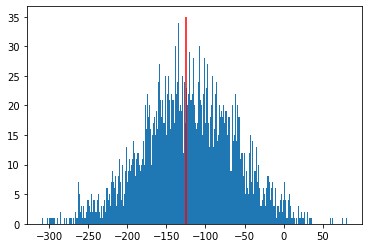

In [62]:
sample = [critic.sample(test_init_state, test_init_command, test_init_action) for _ in range(5000)]

print(torch.cat(sample).mean(dim=0))

plt.hist(torch.cat(sample)[:, 0].numpy(), bins=600);
plt.vlines(test_episode.total_return, 0, 35, colors="red");

In [63]:
def episode_stats(env_name, critic, actor=None, controller=None):
    episode = sample_episode(gym.make(env_name), actor, controller)

    state = torch.tensor(episode.states, dtype=torch.float32)
    command = torch.tensor(episode.commands, dtype=torch.float32)

    action = torch.tensor(episode.actions, dtype=torch.float32)
    action = F.one_hot(action.long(), num_classes=4)
    
    episode_x = torch.cat([state, command, action], dim=1)

    log_alpha, mu, sigma = critic.model(episode_x)

    for i in range(int(episode.length)):
        output_h = int(episode.length) - i
        output_r = np.sum(episode.rewards[i:])

        pred_mean = critic.mean(state[i].unsqueeze(0), command[i].unsqueeze(0), action[i].unsqueeze(0))[0]
            
        print(f"Step {i} " + "=" * 50)
        print(f"Outcome: {[output_r, output_h]}") 
        print(f"Predicted outcome means: {pred_mean.detach().numpy()}")
        print(f"Mixture means:\n {mu[i].detach().numpy()}")
        print(f"Mixture stds:\n {sigma[i].detach().numpy()}")
        print()

In [65]:
# %%capture cap --no-stderr
episode_stats(env_name="LunarLander-v2", critic=critic)

Step 0 ==================================================
Outcome: [-81.25610534531423, 76]
Predicted outcome means: [-130.04733   78.5342 ]
Mixture means:
 [[-7.1867766e+00  6.0447402e+00]
 [-1.7730795e+00  2.7179208e-01]
 [-1.3004755e+02  7.8534332e+01]
 [ 1.0903196e+00  7.7486438e-01]
 [-1.0095317e+00 -4.5954857e-02]]
Mixture stds:
 [[1.2013427e+03 4.7584722e+03]
 [3.1391349e+00 1.0267458e+00]
 [3.6265774e+01 4.5767326e+00]
 [1.3533528e-01 4.1670763e-01]
 [4.0819582e-01 1.6086040e+00]]

Step 1 ==================================================
Outcome: [-82.58252590163883, 75]
Predicted outcome means: [-133.49974   77.30684]
Mixture means:
 [[  -6.95221       5.8286633 ]
 [  -1.7290593     0.195382  ]
 [-133.49986      77.30691   ]
 [   1.2154683     0.6096372 ]
 [  -1.2867476     0.14678344]]
Mixture stds:
 [[1.0621005e+03 4.4885439e+03]
 [2.7311642e+00 1.0992587e+00]
 [4.2281555e+01 4.7397156e+00]
 [1.3533528e-01 5.1081073e-01]
 [4.2992094e-01 1.5593632e+00]]

Step 2 =============

Step 54 ==================================================
Outcome: [-83.19987768256073, 22]
Predicted outcome means: [-55.320187  15.319704]
Mixture means:
 [[ -3.9849186    4.678334  ]
 [ -1.2253603    0.11365372]
 [-55.330284    15.321809  ]
 [  0.12622544   0.8020386 ]
 [ -0.82801896  -0.32053253]]
Mixture stds:
 [[2.8468652e+02 3.5754306e+02]
 [1.3609105e+00 8.9692026e-01]
 [1.0336984e+02 1.0277566e+00]
 [1.5711793e-01 8.8466114e-01]
 [3.7942308e-01 7.8435308e-01]]

Step 55 ==================================================
Outcome: [-81.53992897502883, 21]
Predicted outcome means: [-58.523544  13.998091]
Mixture means:
 [[ -4.201535     4.7007756 ]
 [ -1.019337     0.31933916]
 [-58.57086     14.006205  ]
 [  0.09573828   0.95454675]
 [ -0.5756998   -0.5203651 ]]
Mixture stds:
 [[2.7221576e+02 3.6721786e+02]
 [1.5525897e+00 8.8989908e-01]
 [3.2221191e+01 7.9053026e-01]
 [1.5031527e-01 6.3573945e-01]
 [2.9470146e-01 9.9973631e-01]]

Step 56 ========================================

In [14]:
def rollout(actor, desired_return, desired_horizon):
    env = gym.make("LunarLander-v2")

    state, done = env.reset(), False
    
    total_return, steps = 0.0, 0.0
    while not done:
        command = np.array([desired_return, desired_horizon])
        
        action = actor.act(state, command)
        state, reward, done, _ = env.step(action)
        
        desired_return = min(desired_return - reward, env.reward_range[1])
        desired_horizon = max(desired_horizon - 1, 1)
        
        total_return += reward
        steps += 1
        
    return total_return, steps